In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


models/transfer_withgain_512:

Average FID: 75.52863769238729227272

Maximum FID: 115.51018689531007 (in subdirectory 16)

Minimum FID: 38.7466294030555 (in subdirectory 6)

In [7]:
import torch
from src.diffusion import GaussianDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs

n = 4
device = "cuda:0"
# 32, 4, 15 - very dark
# 23, 25, 20 - bright, noisy
# 32, 15, 10 - multiple clusters
# 15, 15, 20 - thin line
# 19, 15, 20 - thicker line, more up and bent
# 25, 15, 20 - blob on the left, vague line from it, noisy
# 25, 15, 40 - crazy bright smudge
# 
# 12-26, 10.5-38, 10-40
E = 25
P = 15
ms = 20

model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/basic_1dx10_beampos/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
betas = prepare_noise_schedule(noise_steps=700, beta_start=1e-4, beta_end=0.02)
diffusion = GaussianDiffusion(betas=betas, img_width=128, img_height=64, device=device, noise_steps=2)
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = diffusion.sample_ddpm(model, n, y, cfg_scale=5, resize=[256, 512])
# print(x)
plot_image_pairs(x, xlim=[2,20], acquisition_time_ms=ms, electron_pointing_pixel=62)
# plot_images(x)
# save_samples(x)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


0.11372549019607843
0.12549019607843137
0.11764705882352941
0.09411764705882353
0.1607843137254902
0.1450980392156863
0.15294117647058825
0.10980392156862745


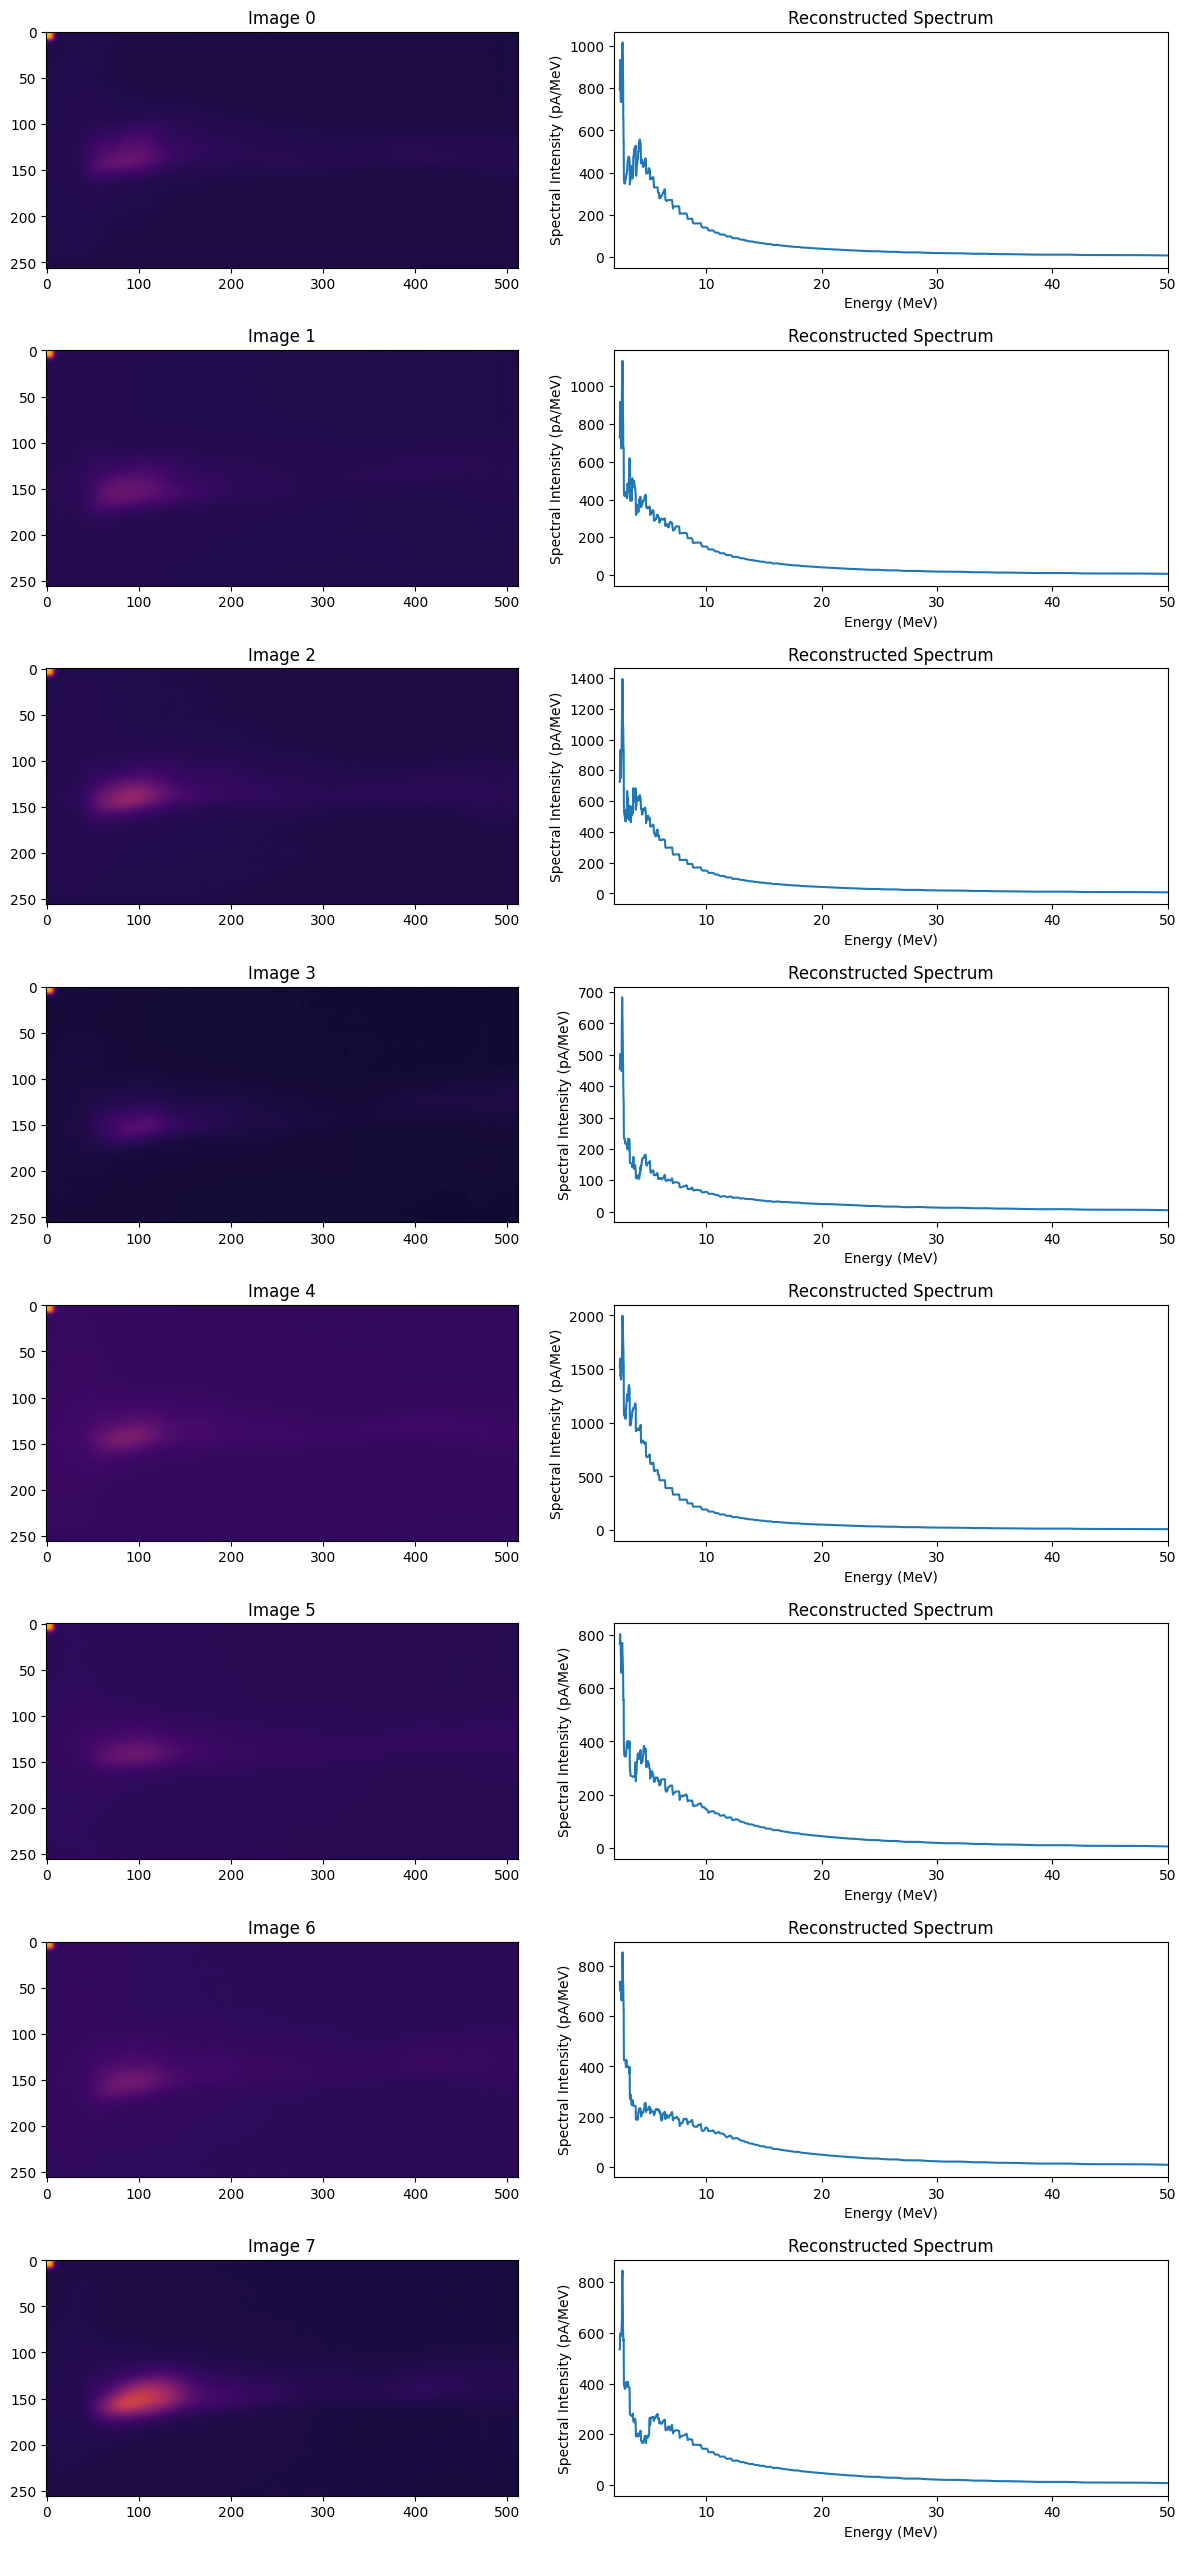

In [3]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion
from src.modules import UNet_conditional
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs
# 32, 4, 15 - very dark
# 23, 25, 20 - bright, noisy
# 32, 15, 10 - multiple clusters
# 15, 15, 20 - thin line
# 19, 15, 20 - thicker line, more up and bent
# 25, 15, 20 - blob on the left, vague line from it, noisy
# 25, 15, 40 - crazy bright smudge
n = 8
device = "cuda:3"
E = 35
P = 16
ms = 10

ns = 700

model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/physinf_noclamp/ema_ckpt.pt", map_location=device)
# ckpt = torch.load("models/transfer_withgain_512/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=ns, section_counts=[15], img_height=64, img_width=128, device=device, rescale_timesteps=False)

# noise_steps: 278 - grey image, 279 - black image

y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = sampler.ddim_sample_loop(model=model, y=y, cfg_scale=4, device=device, eta=1, n=n)
plot_image_pairs(x, xlim=[2,50], acquisition_time_ms=ms, electron_pointing_pixel=62)

# betas=
# model_mean_type=ModelMeanType.eps
# model_var_type="fixed_large"
# loss_type=mse
# rescale_timesteps=False
# use_timesteps=space_timesteps(num_timesteps=self.T=1000,section_counts=f'ddim{T}')